In [5]:
# importing all packages
from matplotlib import pyplot as plt
import numpy as np
from meshoid import Meshoid
import snaputils
import h5py
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [9]:
snap_head, pt5, pt0 = snaputils.read_snapshot_info('snapshot_150.hdf5', 'sph')

In [10]:
# centering the coords prior to the radius cut
pos = pt0["Coordinates"] 
center = np.median(pos,axis=0)
pos -= center

# doing a radius cut, default was 40 for max radius
MAX_RADIUS = 40
radius_cut = np.sum(pos*pos,axis=1) < MAX_RADIUS * MAX_RADIUS
pos, mass, hsml = pos[radius_cut], pt0["Masses"][radius_cut], pt0["SmoothingLength"][radius_cut]
center_new = np.average(pos,axis=0,weights=mass) # another re-centering
center += center_new
pos -= center_new

# now get the principal axes - eigenvectors of the second mass moment matrix
cov_pos = np.cov(pos.T, aweights=mass)
w, coordinate_basis = np.linalg.eigh(cov_pos)
coordinate_basis = coordinate_basis[:,w.argsort()[::-1]] # sort so the smallest moment axis is the last = z-axis
pos = pos @ coordinate_basis # dot product with each basis vector to get coordinates in new basis

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


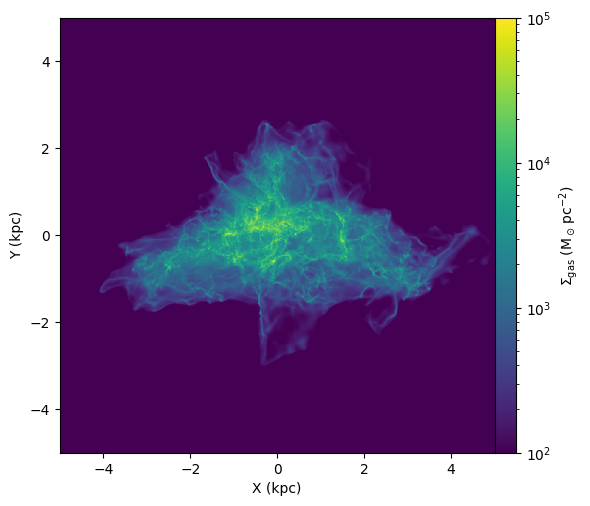

In [11]:
# make sure to convert label, axes, data, rmax, etc to ensure in the right units -> can do Msun/pc2, g/cm2, this is probably in Msun/au2

M = Meshoid(pos, mass, hsml)
rmax = 5 # put units here, etc
res = 1024
X = Y = np.linspace(-rmax, rmax, res)
X, Y = np.meshgrid(X, Y, indexing='ij')
fig, ax = plt.subplots(figsize=(6,6))
sigma_gas_msun_pc2 = M.SurfaceDensity(M.m,center=np.array([0,0,0]),size=rmax,res=res)
p = ax.pcolormesh(X, Y, sigma_gas_msun_pc2, norm=colors.LogNorm(vmin=1e2,vmax=1e5)) #
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.0)
fig.colorbar(p,label=r"$\Sigma_{\rm gas}$ $(\rm M_\odot\,pc^{-2})$",pad=0,cax=cax)
ax.set_aspect('equal')
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
plt.tight_layout(h_pad=1)
plt.show()